<a href="https://colab.research.google.com/github/Elieser1945/DeepLearning/blob/main/GRU_Model_(PyTorch)_IMDB_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **📌 GRU Model (PyTorch) IMDB Dataset**

# Install Library

In [20]:
!pip install torch torchvision scikit-learn matplotlib seaborn --quiet

# Import Library

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load Dataset IMDB

In [23]:
num_words = 30000
maxlen = 300
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

x_train_tensor = torch.LongTensor(x_train)
y_train_tensor = torch.FloatTensor(y_train)
x_test_tensor = torch.LongTensor(x_test)
y_test_tensor = torch.FloatTensor(y_test)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Arsitektur GRU PyTorch

In [24]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.gru(x)
        x = F.relu(self.fc1(h_n[-1]))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()

# Training function

In [25]:
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((outputs > 0.5).float() == labels).sum().item()
    return total_loss / len(train_loader), correct / len(train_loader.dataset)

# Evaluation function

In [26]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(outputs.cpu().numpy())
    return total_loss / len(test_loader), correct / len(test_loader.dataset), y_true, y_pred, y_prob

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUClassifier(num_words, 128, 128).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model

In [28]:
train_losses, val_losses, train_accs, val_accs = [], [], [], []
for epoch in range(10):
    train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, y_true, y_pred, y_prob = evaluate_model(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1, Train Loss: 0.5594, Val Loss: 0.5699, Val Acc: 0.7016
Epoch 2, Train Loss: 0.3260, Val Loss: 0.3311, Val Acc: 0.8582
Epoch 3, Train Loss: 0.2145, Val Loss: 0.3041, Val Acc: 0.8760
Epoch 4, Train Loss: 0.1436, Val Loss: 0.3321, Val Acc: 0.8794
Epoch 5, Train Loss: 0.0927, Val Loss: 0.3844, Val Acc: 0.8803
Epoch 6, Train Loss: 0.0570, Val Loss: 0.4363, Val Acc: 0.8726
Epoch 7, Train Loss: 0.0379, Val Loss: 0.5371, Val Acc: 0.8690
Epoch 8, Train Loss: 0.0205, Val Loss: 0.5432, Val Acc: 0.8746
Epoch 9, Train Loss: 0.0230, Val Loss: 0.5430, Val Acc: 0.8725
Epoch 10, Train Loss: 0.0194, Val Loss: 0.5285, Val Acc: 0.8736


# Evaluasi Akurasi, Presisi, Recall, F1 Squared, AUC dan ROC

In [29]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc_score = auc(fpr, tpr)
accuracy = np.mean(np.array(y_pred) == np.array(y_true))

print("\n-----Evaluasi Akhir-----")
print(f"Akurasi: {accuracy:.4f}")
print(f"Presisi: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc_score:.4f}")


-----Evaluasi Akhir-----
Akurasi: 0.8736
Presisi: 0.8682
Recall: 0.8809
F1-Score: 0.8745
AUC: 0.9452


# Visualisasi

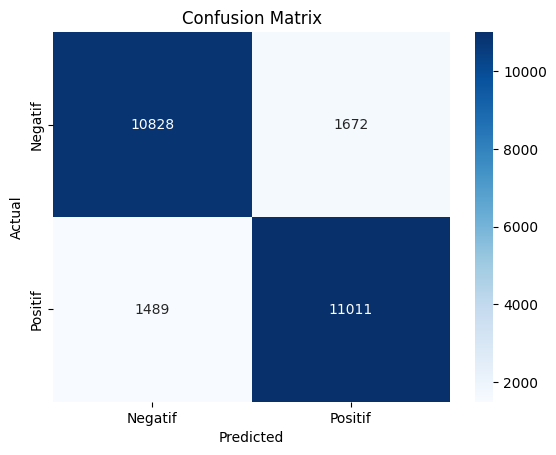

In [30]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

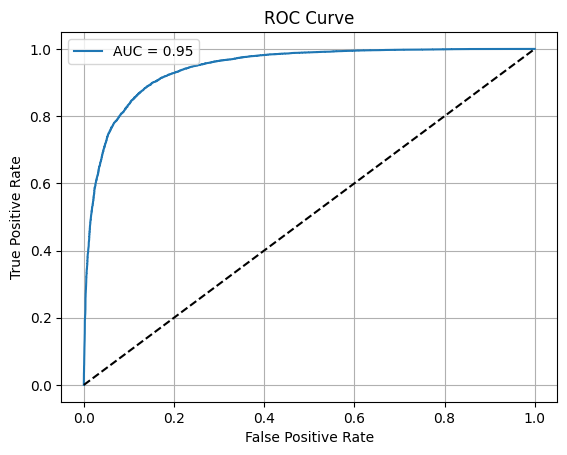

In [31]:
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

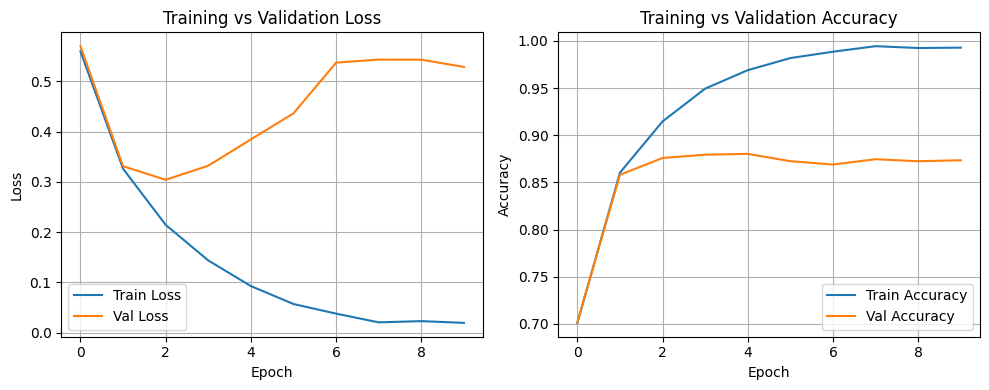

In [32]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Contoh Prediksi Model

In [33]:
print("\nContoh Prediksi:")
for i in range(5):
    print(f"Sample {i+1}: Predicted = {'Positif' if y_pred[i] else 'Negatif'}, Actual = {'Positif' if y_true[i] else 'Negatif'}")


Contoh Prediksi:
Sample 1: Predicted = Negatif, Actual = Negatif
Sample 2: Predicted = Positif, Actual = Positif
Sample 3: Predicted = Positif, Actual = Positif
Sample 4: Predicted = Positif, Actual = Negatif
Sample 5: Predicted = Positif, Actual = Positif
